## Starbucks Capstone Challenge

### Overview
In this project we utilize simulated data from Starbucks App to get insights on custome's behaivor with offers.
The data consists of three parts 
1. portfolio - which includes information about each offer.
2. profile - which includes informtion about each customer.
3. transcript - which includes data about the offer's and customer transactions.

These datasets are discussed in more details in this notebook

### Problem Statement
Given the cutomers' information can we predict if a certain offer is successful or not. I believe that a successful offer must be received by the customer, then viewed, then completed within the offer's duration.

### Metrics
I will be utlizing the accuracy, recall, and f-score as evaluation metric for the different models that i will build.


### Importing libraries¶

In [22]:
#Import necessary libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
import matplotlib.pyplot as plt
import visuals as vs
%matplotlib inline

import os

### Reading the Data
......

In [79]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration

**portfolio data frame consiste of the following columns**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
#checking missing valuse
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

#### Cleaning portfolio data
1. Encoding offer_type using one-hat encode.
2. Cerate four new binary colum in replace to channels.
3. Normalize difficulty,duration,and reward columns.

In [5]:
#Encoding offer_type using one-hat encode.
portfolio = pd.get_dummies(portfolio,columns=['offer_type'])
#Cerate four new binary colum in replace to channels.
channels = []
for value in portfolio['channels']:
    channels.extend(value)
channels = set(channels)
for c in channels:
    portfolio[c] = portfolio['channels'].apply(lambda x: 1 if c in x else 0)
portfolio.drop('channels', axis=1, inplace=True)
#Normalize difficulty,duration,and reward columns.
scaler = MinMaxScaler()
numeric= ['difficulty','duration','reward']
portfolio[numeric] = scaler.fit_transform(portfolio[numeric])

In [6]:
portfolio.head()

,reward,difficulty,duration,id,offer_type_bogo,offer_type_discount,offer_type_informational,email,web,social,mobile
0,1.0,0.50,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,0,1,1
1,1.0,0.50,0.285714,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0.0,0.00,0.142857,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,0.5,0.25,0.571429,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,0.5,1.00,1.000000,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,1,0,0


#### Visualizing porifolio data frame

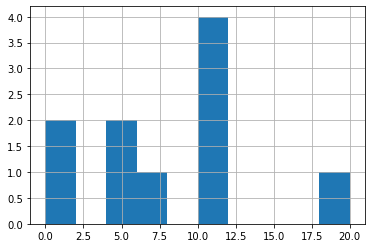

In [82]:
#comparing offer channels 
portfolio.difficulty.hist()


**profile data frame consiste of the following columns**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [78]:
profile.head()

,age,id,income,year,gender_F,gender_M,gender_O
1,0.445783,0610b486422d4921ae7d2bf64640c50b,0.911111,2017,1,0,0
3,0.686747,78afa995795e4d85b5d9ceeca43f5fef,0.777778,2017,1,0,0
5,0.602410,e2127556f4f64592b11af22de27a7932,0.444444,2018,0,1,0
8,0.566265,389bc3fa690240e798340f5a15918d5c,0.255556,2018,0,1,0
12,0.481928,2eeac8d8feae4a8cad5a6af0499a211d,0.233333,2017,0,1,0


In [9]:
#checking missing valuse
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

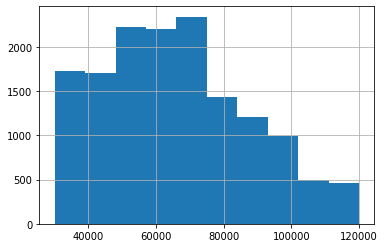

In [80]:
profile.income.hist()

#### Visualizing porifolio data frame

#### Cleaning profile data
1. Drop raws with missing valus.
2. Normilize income using min-max scale.
3. Normilize age using min-max scale.
4. use only the year on became_member_on
5. encode gender column

In [81]:
# Drop raws with missing valus.
profile = profile.dropna()
# Normilize income using min-max scale
scaler = MinMaxScaler() # default=(0, 1)
numeric = ['age','income']
profile[numeric] = scaler.fit_transform(profile[numeric])
# Use only the year on became_member_on
profile['year'] = profile['became_member_on'].astype(str)
profile['year'] = pd.to_datetime(profile.year).dt.year
profile.drop(columns=['became_member_on'],axis=1,inplace=True)
# Encode gender column
profile = pd.get_dummies(profile,columns=['gender'])


In [11]:
profile.head()

,age,id,income,year,gender_F,gender_M,gender_O
1,0.445783,0610b486422d4921ae7d2bf64640c50b,0.911111,2017,1,0,0
3,0.686747,78afa995795e4d85b5d9ceeca43f5fef,0.777778,2017,1,0,0
5,0.602410,e2127556f4f64592b11af22de27a7932,0.444444,2018,0,1,0
8,0.566265,389bc3fa690240e798340f5a15918d5c,0.255556,2018,0,1,0
12,0.481928,2eeac8d8feae4a8cad5a6af0499a211d,0.233333,2017,0,1,0


**transcript data frame consiste of the following columns**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [ ]:
transcript.head()

In [12]:
#checking missing valuse
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [13]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

#### Clean the transcirpt dataframe
the offer_id and the value are stored in the same column. Therefore, i will split them into two different columns.

In [16]:
portfolio.head()

,reward,difficulty,duration,id,offer_type_bogo,offer_type_discount,offer_type_informational,email,web,social,mobile
0,1.0,0.50,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,0,1,1
1,1.0,0.50,0.285714,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0.0,0.00,0.142857,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,0.5,0.25,0.571429,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,0.5,1.00,1.000000,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,1,0,0


In [17]:
offers = transcript[transcript['event'] != 'transaction']
offers['offer_id'] = ""
offers['reward'] = ""

for i, row in offers.iterrows():
    if len(row.value) > 1:
        offers.at[i,'offer_id'] = list(row.value.items())[0][1]  
        offers.at[i,'reward'] = list(row.value.items())[1][1]        
    else:
        offers.at[i,'offer_id'] = list(row.value.items())[0][1]
informational_offer_id = portfolio.id[portfolio['offer_type_informational'] == 1]
offers.drop(offers[offers['offer_id'].isin(informational_offer_id)].index, inplace=True)

C:\Users\anqur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\anqur\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\anqur\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http:

In [18]:
offers.head()

,person,event,value,time,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,


#### determine if offer is successful
the offer must be recieved, viewed, then completed within the offer validity date to be considered successful

In [49]:
offers_file_path = "offers_csv"

if os.path.exists(offers_file_path):
    offers_df = pd.read_csv(offers_file_path)
else:

    offers_df = pd.DataFrame(columns=['person', 'offer_id', 'offer_received', 'offer_viewed','offer_completed', 'offer_successful'])
    for p in profile.id:
        p_tran = offers[offers.person.isin([p])]
        offer_rec = p_tran[p_tran.event.isin(['offer received'])]
        for i, row in offer_rec.iterrows():
            offer_dur = list(portfolio[portfolio.id == row['offer_id']].duration)[0] * 24

            offer_vc = p_tran[p_tran.time.between(int(row['time']), int(row['time']) + offer_dur) & p_tran.event.isin(['offer viewed', 'offer completed']) & (p_tran.offer_id == row.offer_id)]
            offer_viewed = len(offer_vc[offer_vc.event == 'offer viewed'] )
            offer_c = len(offer_vc[offer_vc.event == 'offer completed'] )
            offer_i = offer_viewed & offer_c
            offers_df = offers_df.append(pd.Series([p, row['offer_id'], 1,offer_viewed,offer_c,offer_i ], index=offers_df.columns ), ignore_index=True)
    offers_df['offer_completed_wo_view'] = ((offers_df['offer_viewed'] == 0) & (offers_df['offer_completed'] > 0)).astype(int)
    offers_df.to_csv(offers_file_path)

    #### Creating a new dataframe that combines all the features prior to training
    Now I will create a new dataframe that will combine all of the features so we can use it in training our model.

In [50]:
profile.head()
offer_df_new.head()

,id_x,offer_id,offer_successful,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,email,web,social,mobile,age,id,income,year,gender_F,gender_M,gender_O
0,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,False,0.5,0.25,0.571429,1,0,0,1,1,0,1,0.445783,0610b486422d4921ae7d2bf64640c50b,0.911111,2017,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,False,0.5,0.25,0.571429,1,0,0,1,1,0,1,0.686747,78afa995795e4d85b5d9ceeca43f5fef,0.777778,2017,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,False,1.0,0.50,0.571429,1,0,0,1,0,1,1,0.686747,78afa995795e4d85b5d9ceeca43f5fef,0.777778,2017,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,False,0.5,0.25,0.285714,1,0,0,1,1,1,1,0.686747,78afa995795e4d85b5d9ceeca43f5fef,0.777778,2017,1,0,0
4,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,False,0.5,0.25,0.571429,1,0,0,1,1,0,1,0.602410,e2127556f4f64592b11af22de27a7932,0.444444,2018,0,1,0


In [51]:
offer_df_new= pd.DataFrame(columns=['id', 'offer_id', 'offer_successful'])
offer_df_new['id'] = offers_df['person']
offer_df_new['offer_id'] = offers_df['offer_id']
offer_df_new['offer_successful'] = offers_df['offer_successful'].astype(bool)
offer_df_new= offer_df_new.merge(portfolio, left_on ='offer_id',right_on='id')
offer_df_new.drop('id_y', axis=1,inplace=True)
offer_df_new= offer_df_new.merge(profile, left_on='id_x',right_on='id')

In [52]:
offer_df_new.head()

,id_x,offer_id,offer_successful,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,email,web,social,mobile,age,id,income,year,gender_F,gender_M,gender_O
0,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,False,0.5,0.25,0.571429,1,0,0,1,1,0,1,0.445783,0610b486422d4921ae7d2bf64640c50b,0.911111,2017,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,False,0.5,0.25,0.571429,1,0,0,1,1,0,1,0.686747,78afa995795e4d85b5d9ceeca43f5fef,0.777778,2017,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,False,1.0,0.50,0.571429,1,0,0,1,0,1,1,0.686747,78afa995795e4d85b5d9ceeca43f5fef,0.777778,2017,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,False,0.5,0.25,0.285714,1,0,0,1,1,1,1,0.686747,78afa995795e4d85b5d9ceeca43f5fef,0.777778,2017,1,0,0
4,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,False,0.5,0.25,0.571429,1,0,0,1,1,0,1,0.602410,e2127556f4f64592b11af22de27a7932,0.444444,2018,0,1,0


In [53]:
offer_successful = offer_df_new['offer_successful']
offer_df = offer_df_new.drop(['offer_successful','id','id_x','offer_id','offer_type_informational'], axis=1)

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.



In [54]:

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(offer_df, 
                                                    offer_successful, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 42560 samples.
Testing set has 10641 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

In [55]:
'''
TP = np.sum(offer_successful) # Counting the ones as this is the naive case. Note that 'offer_successful' is the 'offer_successful_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = offer_successful.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
accuracy = (np.sum(offer_successful)*1.0)/offer_successful.count()
recall = (np.sum(offer_successful)*1.0)/((np.sum(offer_successful)*1.0)+0)
precision = (np.sum(offer_successful)*1.0)/offer_successful.count()

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+0.5**2)*(precision*recall)/((precision*0.5**2)+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.0703, F-score: 0.0864]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

after trying a random subset of the data on the diffrante classifiers I have selected: Support Vector Machines, Random Forest, and Gaussian Naive Bayes.

Support Vector Machines
- SVM is applied on the field of image processing an example is face detection. [link](https://papers.nips.cc/paper/1609-support-vector-machines-applied-to-face-recognition.pdf)

- Weakness: high computational cost for training  

- strength: SVM will have one unique optimal solution since the problem will be convex. 

- Snice our problem is binary classification SVM might perform well


Random Forest
- A real-world application of Random Forest is  tumor classification based on tissue microarray data. [link](https://www.nature.com/articles/3800322)

- Weakness: The prediction time might be high compared to decision trees. 

- strength: Overcome the problem of overfitting on a normal decision tree.

- Snice our problem has a relatively good number of features I believe Random Forest will be good choose and perform better than normal decision tree.

Gaussian Naive Bayes
- A real-world application of Gaussian Naive Bayes classifier  is  in text categorization .[link]
(http://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf)

- Weakness: assumes that features are independants. 

- strength:  It only requires a small amount of training data to estimate the parameters. [link]
(https://www.ic.unicamp.br/~rocha/teaching/2011s2/mc906/aulas/naive-bayes-classifier.pdf) .

- Since our data set is not that big in size Gaussian Naive Bayes might produce competitive results.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [56]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] =  end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

C:\Users\anqur\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 425 samples.
RandomForestClassifier trained on 4256 samples.
RandomForestClassifier trained on 42560 samples.
SVC trained on 425 samples.


C:\Users\anqur\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\anqur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\anqur\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\anqur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

SVC trained on 4256 samples.


C:\Users\anqur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 42560 samples.
GaussianNB trained on 425 samples.
GaussianNB trained on 4256 samples.
GaussianNB trained on 42560 samples.


C:\Users\anqur\Desktop\caps\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


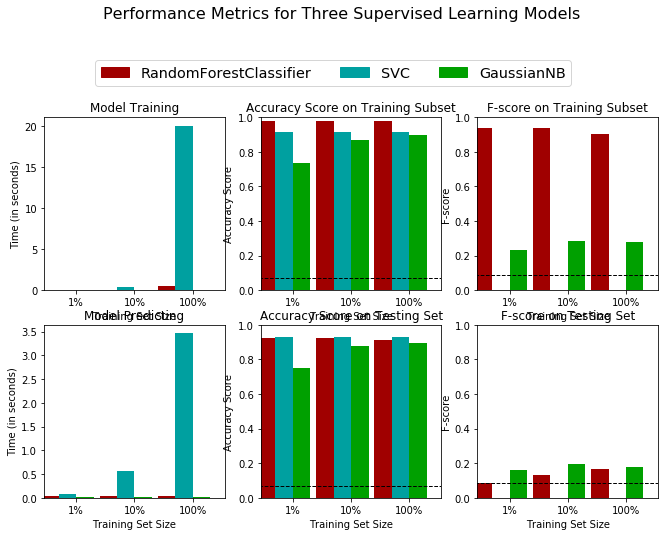

In [58]:
# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state=99)
clf_B = SVC(random_state=99)
clf_C = GaussianNB()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int (len(y_train)*0.1)
samples_1 = int (len(y_train)*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 


Random forst and SVC accurcy is almost the same when testing on 100% of the test data. the F score is shockingly very low for all the models. However, random forest is doing a little bit better than the others. that why i will try to imporve the results of Random Forest.


Decision trees learn by sorting the features based on the information gained(i.e. which will separate the data on better). After sorting the features, the algorithm will decide the threshold that separate the data best for each feature. In predicting the algorithm will check the feature on the predefined order(information gained) until it ends up on one of the class. Random forest creates multiple decision trees using random subsets of the data and random subset of the features for each tree. after creating all the decision trees the model will uses voting to predict the result. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [64]:
# TODO: Initialize the classifier
clf = RandomForestClassifier(random_state=99)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators':[100,200,300], 'min_samples_split': [2,3,4,5], 'min_samples_leaf':[1,2,3,4,5]} 

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\anqur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\anqur\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.9129
F-score on testing data: 0.1656

Optimized Model
------
Final accuracy score on the testing data: 0.9140
Final F-score on the testing data: 0.1586


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.9129      |   0.9140        |
| F-score        |       0.1656      |   0.1586        |



The accuracy score is slightly better for the optimized model compared to the unoptimized model


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

C:\Users\anqur\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


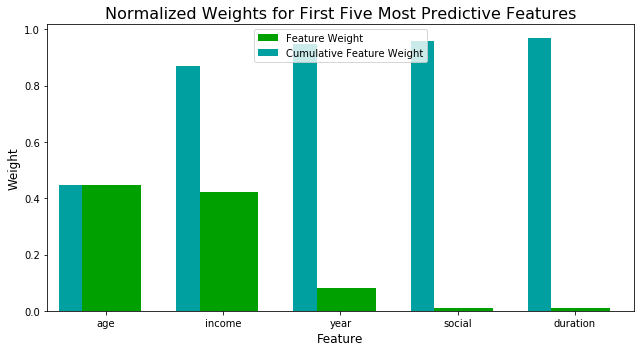

In [66]:
# TODO: Import a supervised learning model that has 'feature_importances_'


# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier().fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

##Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [13]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook  Starbucks_Capstone_Challenge.ipynb to html',
 '[NbConvertApp] Writing 404761 bytes to  Starbucks_Capstone_Challenge.html']